In [1]:
# ******ignore warnings
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
from scipy import stats
import os


# ******files/data
from pydataset import data
import env
import acquire
import prepare


# ******visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# ******sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


np.random.seed(123)

# 01_acquire

In [2]:
raw_telco = acquire.acquire_telco_data()

In [3]:
raw_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

## Columns to Drop

In [4]:
raw_telco.drop(columns = ['total_charges', 'customer_id', 'multiple_lines', 'online_security', 
                         'online_backup', 'device_protection', 'streaming_tv',
                         'streaming_movies',  'contract_type',
                         'internet_service_type','payment_type'], inplace = True)

In [5]:
raw_telco

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,tech_support,paperless_billing,monthly_charges,churn
0,2,1,3,Female,0,Yes,Yes,65,Yes,Yes,Yes,90.45,No
1,4,1,3,Male,0,No,No,54,No,Yes,No,45.20,No
2,3,1,3,Female,0,No,No,56,No,Yes,No,45.05,No
3,4,1,3,Male,0,Yes,Yes,20,No,Yes,Yes,39.40,No
4,3,1,3,Male,0,Yes,No,72,Yes,Yes,Yes,85.15,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2,3,1,Female,0,Yes,Yes,1,Yes,No internet service,No,20.05,No
7039,2,3,1,Female,0,No,No,19,Yes,No internet service,No,19.90,No
7040,4,3,1,Female,0,No,No,6,Yes,No internet service,No,19.70,No
7041,2,3,1,Male,0,No,No,1,Yes,No internet service,No,18.90,No


## Columns to encode
- Gender
- Rest of obj cols

In [6]:
float_cols = []

In [7]:
int_cols = []

In [8]:
obj_cols = []

In [9]:
for col in raw_telco.columns:
    if raw_telco[col].dtype == 'float64':
        float_cols.append(col)
    elif raw_telco[col].dtype == 'int64':
        int_cols.append(col)
    else:
        obj_cols.append(col)

In [10]:
obj_cols

['gender',
 'partner',
 'dependents',
 'phone_service',
 'tech_support',
 'paperless_billing',
 'churn']

In [11]:
for col in obj_cols:
    print(col)
    print(f'Unique Values: {raw_telco[col].nunique()}')
    print('-------')
    print(raw_telco[col].value_counts())
    print('--------------------------')

gender
Unique Values: 2
-------
Male      3555
Female    3488
Name: gender, dtype: int64
--------------------------
partner
Unique Values: 2
-------
No     3641
Yes    3402
Name: partner, dtype: int64
--------------------------
dependents
Unique Values: 2
-------
No     4933
Yes    2110
Name: dependents, dtype: int64
--------------------------
phone_service
Unique Values: 2
-------
Yes    6361
No      682
Name: phone_service, dtype: int64
--------------------------
tech_support
Unique Values: 3
-------
No                     3473
Yes                    2044
No internet service    1526
Name: tech_support, dtype: int64
--------------------------
paperless_billing
Unique Values: 2
-------
Yes    4171
No     2872
Name: paperless_billing, dtype: int64
--------------------------
churn
Unique Values: 2
-------
No     5174
Yes    1869
Name: churn, dtype: int64
--------------------------


In [12]:
# to remove gender and tech_support from obj_cols and create a new list map_sep

obj_cols.remove('gender')
obj_cols.remove('tech_support')

In [13]:
obj_cols

['partner', 'dependents', 'phone_service', 'paperless_billing', 'churn']

In [14]:
# raw_telco['gender'] = raw_telco.gender.map({'Male': 1, 'Female': 0})
for col in obj_cols:
    raw_telco[col] = raw_telco[col].map({'Yes': 1, 'No': 0})

In [15]:
# to map gender

raw_telco.gender = raw_telco.gender.map({'Male': 1, 'Female': 0})

In [16]:
# to map tech_support

dummy_tech_support = pd.get_dummies(raw_telco[['tech_support']])

In [17]:
dummy_tech_support.drop(columns = ['tech_support_No', 'tech_support_No internet service'], inplace = True)

In [18]:
raw_telco = pd.concat([raw_telco, dummy_tech_support], axis = 1)

In [19]:
raw_telco.drop(columns = ['tech_support'], inplace = True)

In [20]:
raw_telco.tech_support_Yes.dtype

dtype('uint8')

In [21]:
raw_telco.rename(columns = {'tech_support_Yes': 'tech_support'}, inplace = True)

In [22]:
discrete_col = []
contin_col = []

for col in raw_telco.columns:
    if raw_telco[col].nunique() < 5:
        discrete_col.append(col)
    else:
        contin_col.append(col)


In [23]:
discrete_col

['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'phone_service',
 'paperless_billing',
 'churn',
 'tech_support']

In [24]:
contin_col

['tenure', 'monthly_charges']

payment_type_id


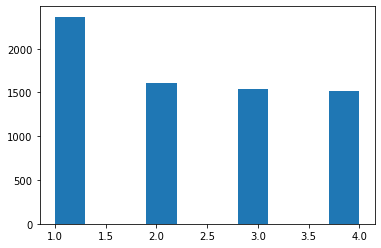

internet_service_type_id


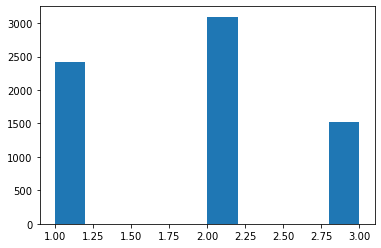

contract_type_id


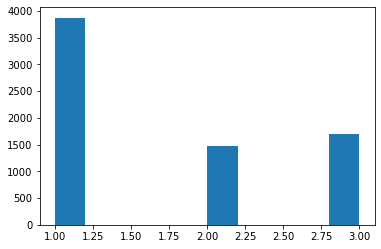

gender


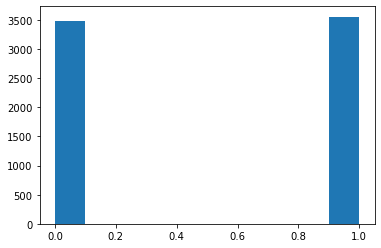

senior_citizen


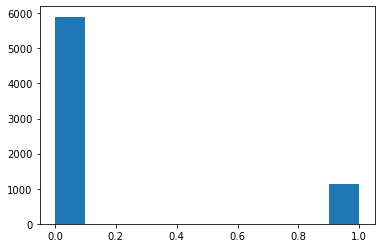

partner


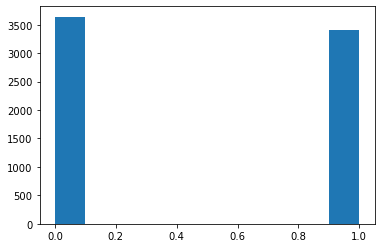

dependents


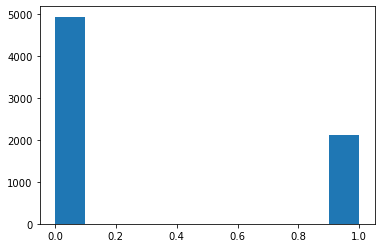

phone_service


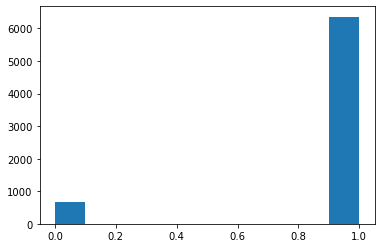

paperless_billing


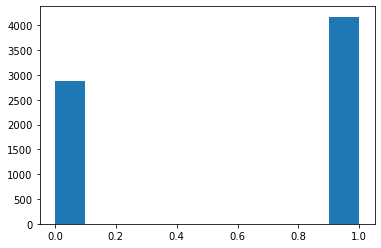

churn


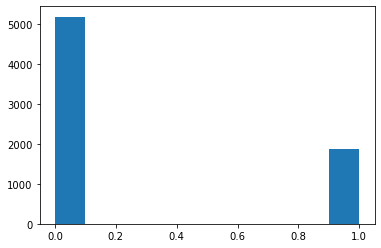

tech_support


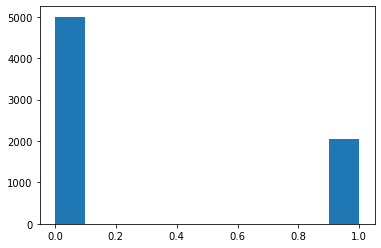

In [25]:
for col in discrete_col:
    print(col)
    plt.hist(raw_telco[col])
    plt.show()

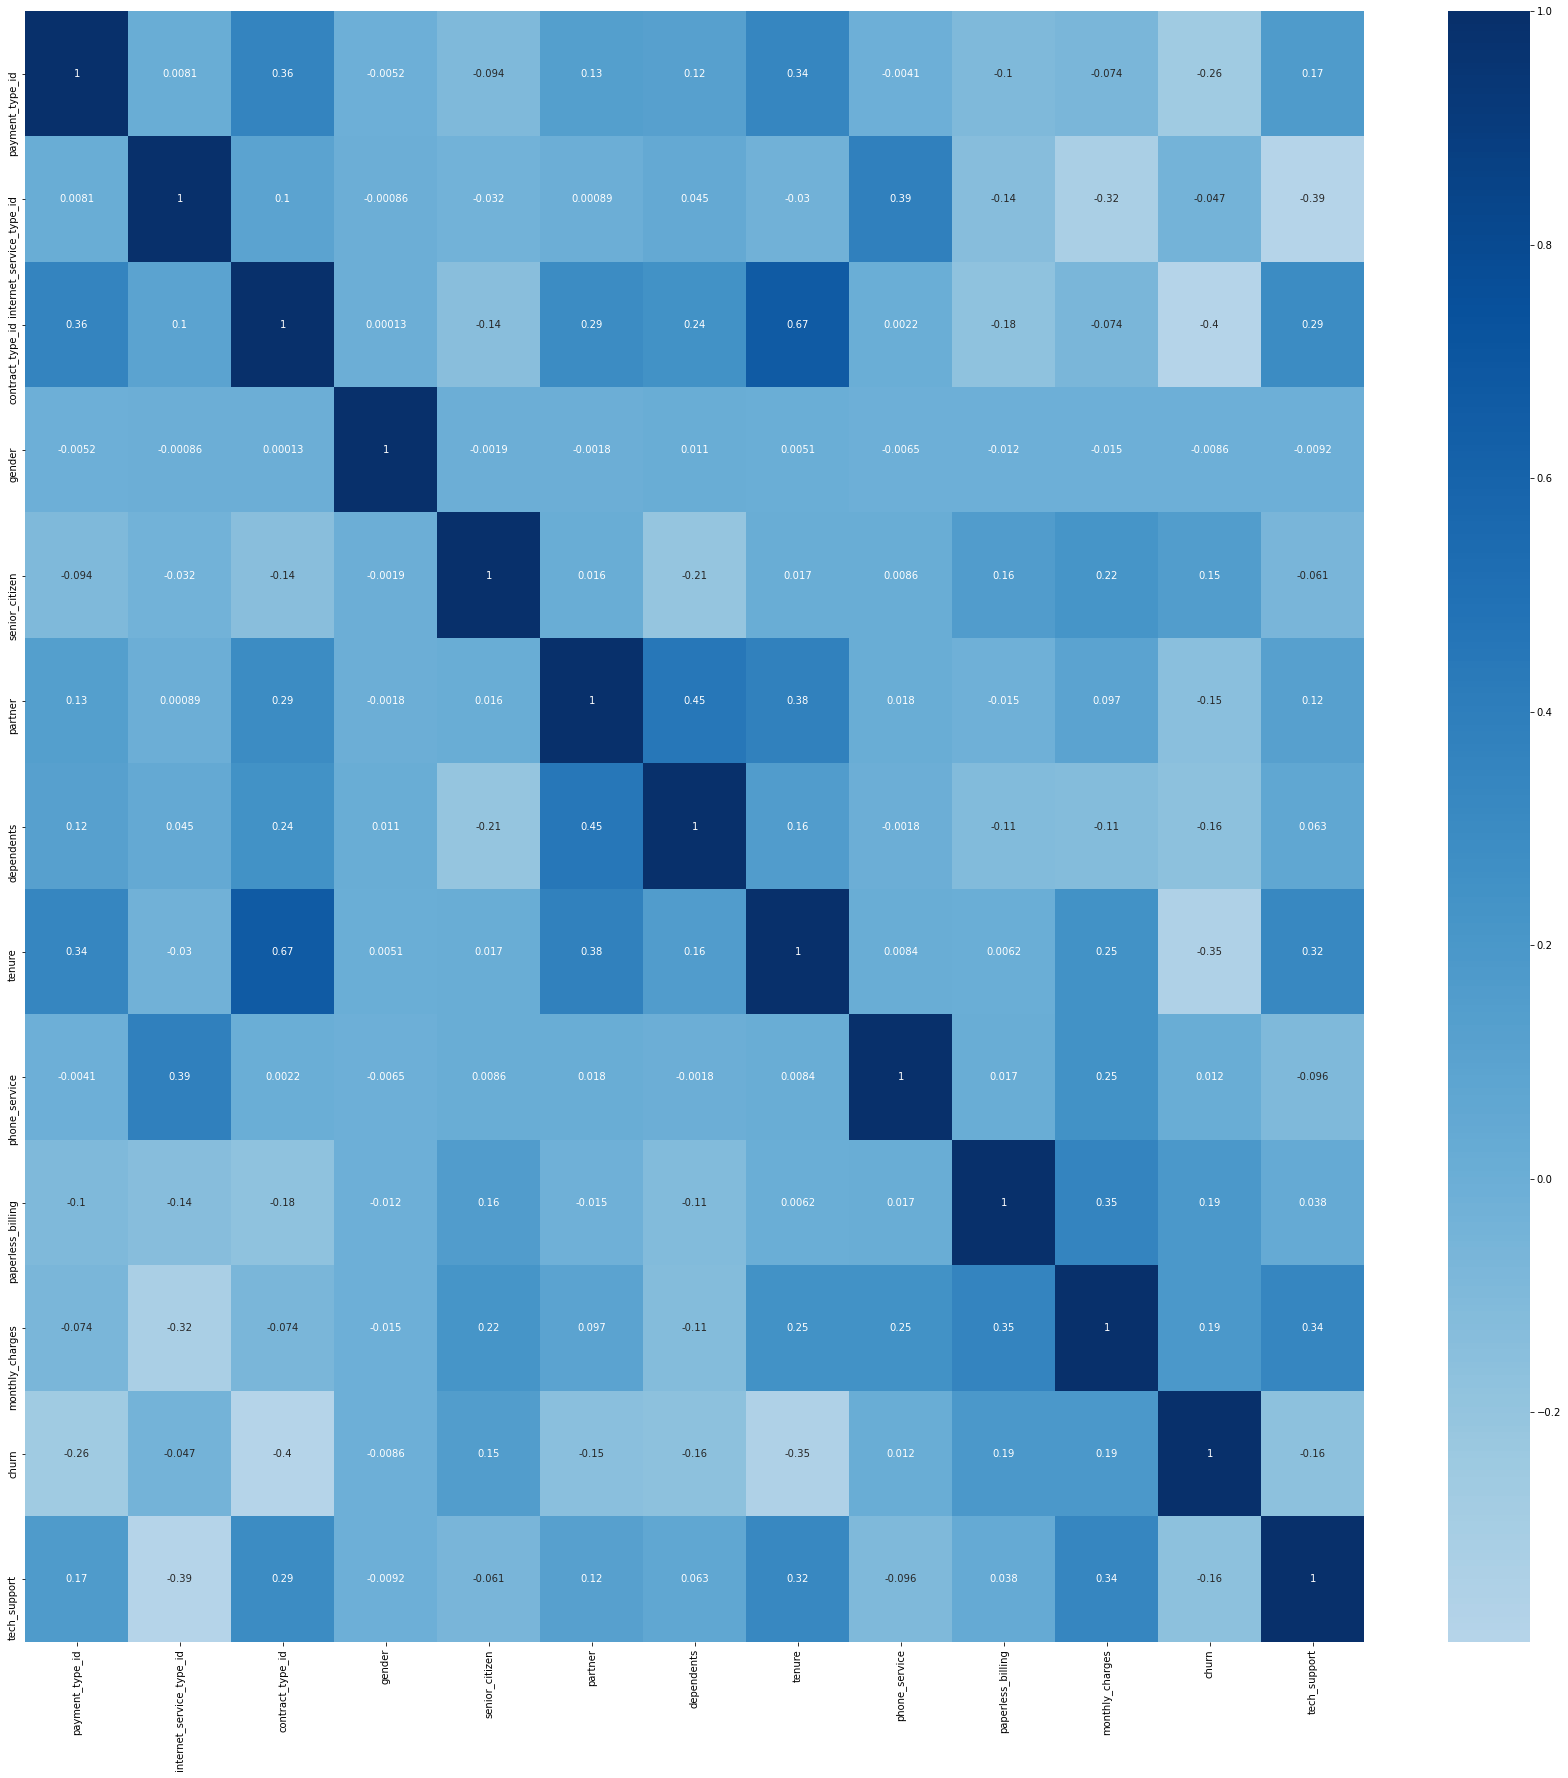

In [26]:
plt.rc('figure', figsize = (30, 30))
plt.rc('font', size = 10)

sns.heatmap(raw_telco.corr(), center = 0, cmap = 'Blues', annot = True)
plt.show()

# Initial Questions
- Do customers who pay by electronic check have shorter tenures?
- Do customers without internet service have fewer issues requiring technical support?
- Do customers with lower monthly charges churn less than those with higher monthly charges?
- Does the type of internet a customer has affect the rate at which they churn?

### Q1. What payment types have the highest and lowest tenures?
- Customers who pay by echeck and mail have the lowest tenures

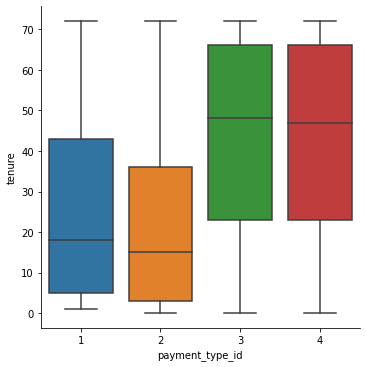

In [32]:
# looking at 
#     raw_telco.payment_type_id
#     raw_telco.tenure

sns.catplot(x="payment_type_id", y="tenure", kind="box", data=raw_telco)

## Follow up to Q1 
#### How does tenure affect churn?

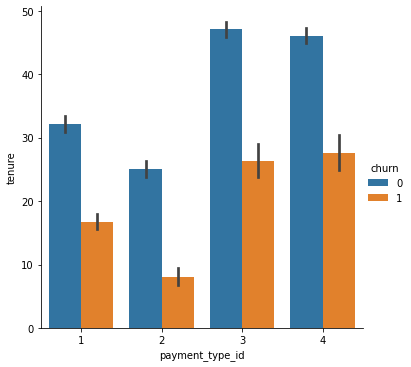

In [50]:
sns.catplot(x="payment_type_id", y="tenure", hue = 'churn', kind = 'bar', data=raw_telco)

Text(0.5, 1.0, 'Almost Half of Customers Who Pay by eCheck are Leaving Telco')

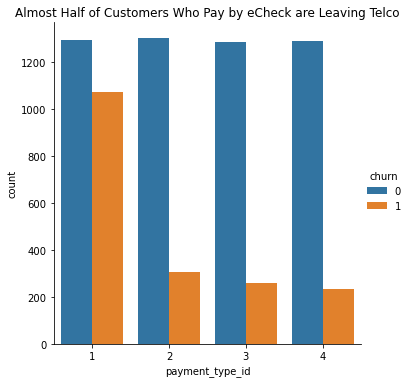

In [53]:
sns.catplot(x="payment_type_id", hue = 'churn', kind = 'count', data=raw_telco)
plt.title('Almost Half of Customers Who Pay by eCheck are Leaving Telco')

In [45]:
print(f'eCheck Churn Rate: {raw_telco[raw_telco.payment_type_id == 1].churn.mean()}')
print(f'Mail Churn Rate: {raw_telco[raw_telco.payment_type_id == 2].churn.mean()}')
print(f'Bank Xfer (auto) Churn Rate: {raw_telco[raw_telco.payment_type_id == 3].churn.mean()}')
print(f'Credit (auto) Churn Rate: {raw_telco[raw_telco.payment_type_id == 4].churn.mean()}')

eCheck Churn Rate: 0.4528541226215645
Mail Churn Rate: 0.19106699751861042
Bank Xfer (auto) Churn Rate: 0.16709844559585493
Credit (auto) Churn Rate: 0.15243101182654403


## Takeaways from Q1
- Customers who pay by electronic check are churning at a very high rate, much higher than any of the other payment types